# Mask R-CNN

In [1]:
%matplotlib inline

In [22]:
import os
import sys
import glob
import random
import math
import numpy as np
import skimage.io
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt

from MaskRCNN.config import Config
import MaskRCNN.utils as utils
import MaskRCNN.model as modellib
import MaskRCNN.visualize as visualize
from MaskRCNN.model import log

In [23]:
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "weights/mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    print("Download the COCO trained weights")
    # utils.download_trained_weights(COCO_MODEL_PATH)
    

In [4]:
train_path = os.path.join(ROOT_DIR, 'input/stage1_train')
test_path = os.path.join(ROOT_DIR, 'input/stage1_test')   #path to test data file/folder

## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [5]:
class NucleiConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "nuclei"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = NucleiConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[32 32]
 [16 16]
 [ 8  8]
 [ 4  4]
 [ 2  2]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  128
IMAGE_MIN_DIM                  128
IMAGE_PADDING                  True
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           nuclei
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         2000
ROI_

In [6]:
class InferenceConfig(NucleiConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

## Notebook Preferences

In [7]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

In [92]:
class NucleiDataset(utils.Dataset):
    """Loads the nuclei dataset.
    """
    
    def load_nuclei(self, path, output_shape=(None, None)):
        '''
        Loads images from path/{id}/images/{id}.png
        '''
        self.add_class("nuclei", 1, "nuclei")
        
        img_info = [(id, '{0}/{1}/images/{1}.png'.format(path, id)) for id in os.listdir(path)]
        for id, path in img_info:
            self.add_image('nuclei', id, path)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "nuclei":
            return info["path"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, path, image_id, output_shape=(None, None)):
        '''
        Loads and concatenates images from path/{id}/masks/{id}.png into a numpy array. 
        Generate instance masks for shapes of the given image ID.
        '''
        info = self.image_info[image_id]
        img_paths = glob.glob('{0}/{1}/masks/*.png'.format(path, info['id']))

#         Y_data = []
        masks = skimage.io.imread_collection(img_paths).concatenate()  #masks.shape = (num_masks, img_height, img_width)
        mask = np.max(masks, axis=0)                                   #mask.shape = (img_height, img_width)
        mask = skimage.transform.resize(mask, output_shape=output_shape+(len(img_paths),), mode='constant', preserve_range=True)
        print(mask.shape)
#         Y_data.append(mask)
        Y_data = np.array(mask, dtype=np.bool)
#         Y_data = np.swapaxes(Y_data, 0, 2)
        
        return Y_data, [0, 1]

In [93]:
# Training dataset
dataset_train = NucleiDataset()
dataset_train.load_nuclei(train_path)
dataset_train.prepare()

In [94]:
print(dataset_train.image_ids[2])
print(dataset_train.image_info[0]['id'])

2
00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552


In [95]:
dataset_train.load_mask(train_path, 0, (180, 180))

(180, 180, 27)


(array([[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],
 
        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],
 
        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, 

In [96]:
def display_top_masks(image, mask, class_ids, class_names, limit=4):
    """Display the given image and the top few class masks."""
    to_display = []
    titles = []
    to_display.append(image)
    titles.append("H x W={}x{}".format(image.shape[0], image.shape[1]))
    # Pick top prominent classes in this image
    unique_class_ids = np.unique(class_ids)
    mask_area = [np.sum(mask[:, :, np.where(class_ids == i)[0]])
                 for i in unique_class_ids]
    top_ids = [v[0] for v in sorted(zip(unique_class_ids, mask_area),
                                    key=lambda r: r[1], reverse=True) if v[1] > 0]
    # Generate images and titles
    for i in range(limit):
        class_id = top_ids[i] if i < len(top_ids) else -1
        # Pull masks of instances belonging to the same class.
        m = mask[:, :, np.where(class_ids == class_id)[0]]
        m = np.sum(m * np.arange(1, m.shape[-1] + 1), -1)
        to_display.append(m)
        titles.append(class_names[class_id] if class_id != -1 else "-")
    print(titles)
    visualize.display_images(to_display, titles=titles, cols=limit + 1, cmap="Blues_r")

In [97]:
def display_masks(image, mask, class_names, limit=2):
    """Display the given image and the top few class masks."""
    to_display = []
    titles = []
    to_display.append(image)
    titles.append("H x W={}x{}".format(image.shape[0], image.shape[1]))
    
    # Generate images and titles
    for i in range(limit):
        class_id = 1
        # Pull masks of instances belonging to the same class.
        m = mask
        print(m.shape)
        to_display.append(m)
        titles.append(class_names[class_id] if class_id != -1 else "-")
    visualize.display_images(to_display, titles=titles, cols=limit + 1, cmap="Blues_r")

(180, 180, 57)
['H x W=256x256', '-', '-']


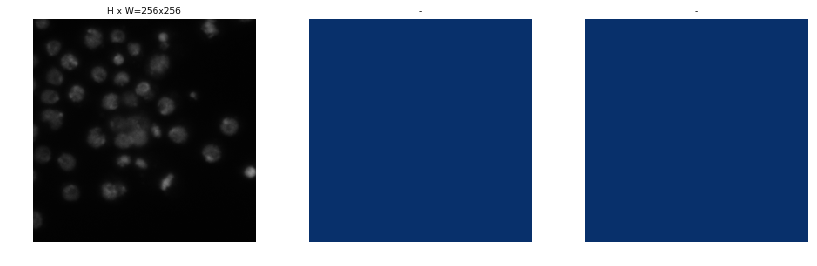

(180, 180, 31)
['H x W=256x256', '-', '-']


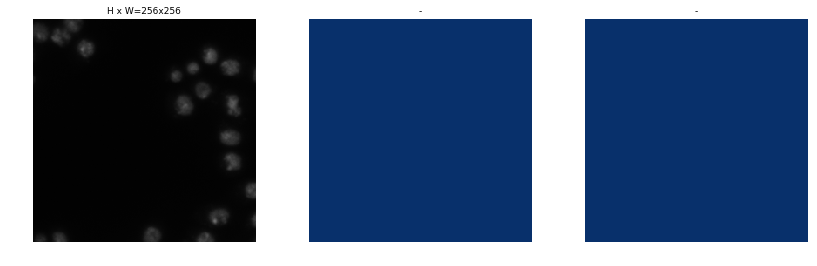

(180, 180, 94)
['H x W=1024x1024', '-', '-']


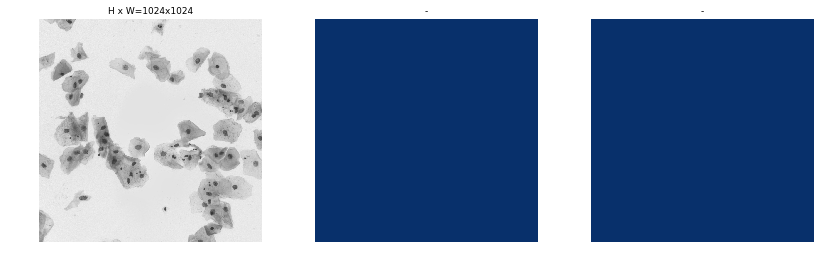

(180, 180, 38)
['H x W=256x256', '-', '-']


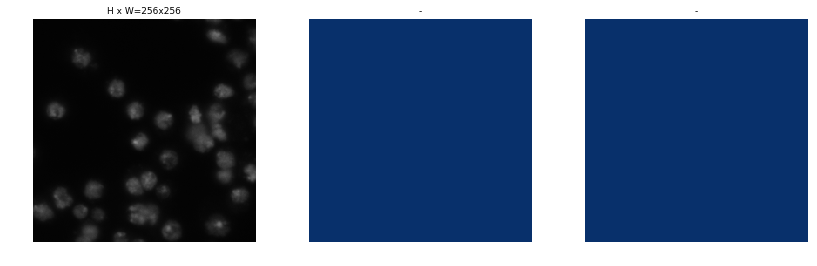

In [98]:
image_ids = np.random.choice(dataset_train.image_ids, 4)
imgs = []
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(train_path, image_id, (180, 180))
    display_top_masks(image, mask,dataset_train.class_ids, dataset_train.class_names, limit=2)